<a href="https://colab.research.google.com/github/joaochenriques/IST---Marine-Currents-and-Tidal-Energy/blob/main/Tidal_Stream/BladeElementMethod/BladeDesign_V14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, root_scalar
from copy import deepcopy
import subprocess
import pathlib
from IPython.display import display
from scipy.optimize import minimize, LinearConstraint

def cmdcall( cmd, verbose = False ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import matplotlib.pyplot as mpl
import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [184]:
print_tables = False    # Output tables can be printed or omitted

rad2deg = 180/np.pi
deg2rad = np.pi/180

# **Tidal stream design**
## The notebook is divided in four parts:

1. Design with Glauert's optimal distribution (inviscid flow solution)
2. Design with tip loss and chord length corrections
3. Offdesign conditions for a single tip speed ratio λ
4. Offdesign conditions for a range tip speed ratios λ


## Class that stores the blade section data for the 4 parts of the solution

In [185]:
class BladeData:

    def CosDist( self, i: int, n: int, ang0_deg: float = 0 ) -> float:
        '''
        Generates a cosine blade section spacing along the span
        '''

        if i == n-1: return 1
        if i == 0: return 0
        csi0 = ang0_deg * deg2rad
        dcsi = ( np.pi - 2 * csi0 ) * i / ( n-1 )
        return ( ( np.cos( np.pi - csi0 - dcsi ) + 1.0 ) * 0.5 )


    def __init__( self, λ_hub: float, λ_tip: float, n: int, linear:bool=False ):
        '''
        λ_hub: hub speed ratio
        λ_tip: tip speed ratio
        n: number of blade sections
        linear: True if the blade sections spacing is linear
        '''

        if linear:
            self.λ_vec = np.linspace( λ_hub, λ_tip, n )
        else:
            self.λ_vec = np.zeros( n )
            for i in range( n ):
                self.λ_vec[i] = ( λ_tip - λ_hub ) * self.CosDist( i, n ) + λ_hub

        self.n = n                      # number of blade sections
        self.λ_hub = λ_hub              # hub speed ratio
        self.λ_tip = λ_tip              # tip speed ratio

        self.a_vec  = np.zeros( n )     # axial induction factor
        self.ap_vec = np.zeros( n )     # tangential induction factor
        self.k_vec  = np.zeros( n )     # Prandtl's tip correction
        self.ϕ0_rad_vec = np.zeros( n ) # relative velocity angle
        self.σ_vec  = np.zeros( n )     # solidity factor
        self.σCLλ_vec = np.zeros( n )   # solidity factor * CL
        self.CP_vec = np.zeros( n )     # power coefficient

        self.α_rad_vec = np.zeros( n )  # angle of attack
        self.CL_vec = np.zeros( n )     # lift coefficient
        self.CD_vec = np.zeros( n )     # drag coefficient

        self.θ_rad_vec  = np.zeros( n ) # pitch angle
        self.rR_vec = np.zeros( n )     # r / radius at the tip
        self.cR_vec = np.zeros( n )     # chord / radius at the tip

## Blade span config

In [186]:
Z = 3           # number of blades
_λ_hub = 0.4    # hub speed ratio
_λ_tip = 4.0    # tip speed ratio
_dλ = 0.1       # increment of λ

# number of sections for the linear case
n = int( ( _λ_tip - _λ_hub ) / _dλ + 0.5 ) + 1

print( f'{n} sections, r_hub / R_tip = {_λ_hub/_λ_tip:0.3f}' )

37 sections, r_hub / R_tip = 0.100


## Blade sections characterization

### The current notebook only considers blades with a single blade section geometry

### **NOTE**: The airfoil data is always in degrees


In [187]:
class NACA_4415:
    '''
    Hydrofoil section data given by a simple equation
    '''

    def design_angle( self ):
        # max( CL/CD ) -> α = 6.09
        return 6.09

    def alpha_limits( self ):
        return -15, 15

    def data( self, α ):
        # Joao Baltazar data
        CL = 0.368 + 0.094 * α
        CD = 0.00994 + ( 0.000259 + 0.0001055 * α ) * α
        return CL, CD

In [188]:
cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/IST---Marine-Currents-and-Tidal-Energy/"
         "main/Tidal_Stream/BladeElementMethod/Foils/DU93-W-210_polar.txt" )

In [189]:
class HydrofoilFromFile:
    '''
    Hydrofoil section data from a file
    '''

    def __init__( self, filename ):

        # df = pd.read_csv( filename, skiprows=[0,1,2,3], usecols=[0,1,3], \
        #                        names=['alpha', 'CL', 'CD'], sep='\s+' )
        df = pd.read_csv( filename, sep=r'\s+' )
        self.alpha = df['alpha'].to_numpy()
        self.CL = df['CL'].to_numpy()
        self.CD = df['CD'].to_numpy()

        CLCD = self.CL / self.CD
        i = np.argmax( CLCD )
        self.α_opt = self.alpha[i]

    def design_angle( self ):
        return self.α_opt

    def alpha_limits( self ):
        return self.alpha[0], self.alpha[-1]

    def data( self, α ):
        if type(α) == np.ndarray:
            assert (α >= self.alpha[0]).all() and (α <= self.alpha[-1]).all()
        else:
            assert α >= self.alpha[0] and α <= self.alpha[-1]

        # linear interpolation of the data
        CL = np.interp( α, self.alpha, self.CL )
        CD = np.interp( α, self.alpha, self.CD )
        return CL, CD

In [190]:
# Hydrofoil = HydrofoilFromFile( 'DU93-W-210_polar.txt' )
Hydrofoil = NACA_4415()

<Figure size 480x360 with 0 Axes>

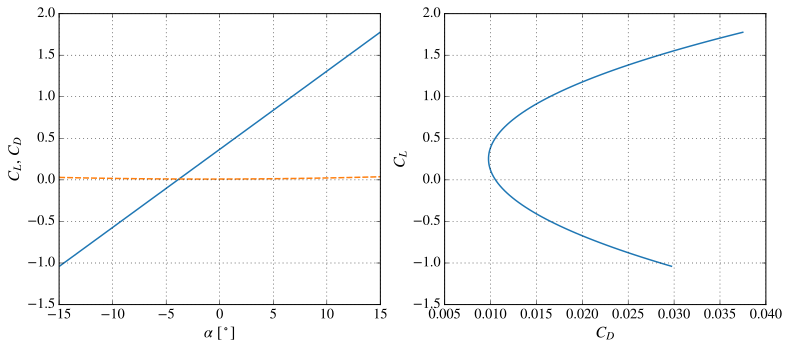

In [191]:
_alpha_vec = np.linspace( *Hydrofoil.alpha_limits(), 100 )
_CL_vec, _CD_vec = Hydrofoil.data( _alpha_vec )

mpl.figure(1)
mpl.subplots( nrows=1, ncols=2, figsize=(12,5) )

mpl.subplot(1,2,1)
mpl.plot( _alpha_vec, _CL_vec )
mpl.plot( _alpha_vec, _CD_vec )
mpl.grid()
mpl.xlabel( r"$\alpha$ [$^\circ$]")
mpl.ylabel( r"$C_L$, $C_D$")

mpl.subplot(1,2,2)
mpl.plot( _CD_vec, _CL_vec )
mpl.grid()
mpl.xlabel( r"$C_D$")
mpl.ylabel( r"$C_L$");

### Airfoil design conditions

In [192]:
α_des  = Hydrofoil.design_angle()
α_des_rad = α_des * deg2rad
CL_des, CD_des = Hydrofoil.data( α_des )

print( f'α_des = {α_des:.2f}°, CL_des = {CL_des:.3f}, CD_des = {CD_des:.3f}, CL/CD = {CL_des/CD_des:.3f}' )

α_des = 6.09°, CL_des = 0.940, CD_des = 0.015, CL/CD = 60.950


# **Part 1** - Design with Glauert's optimal distribution (inviscid flow solution)

In [193]:
def f(y):
    return -64/5 * y**5 - 72 * y**4 - 124 * y**3 - 38 * y**2 + 63 * y + 12 * np.log(y) + 4 / y

def Integral_f( a1, a2, λ_tip ):
    y1 = 1 - 3 * a1
    y2 = 1 - 3 * a2
    return 8 / ( 729 * λ_tip**2 ) * ( f(y2) - f(y1) )

In [194]:
dti = BladeData( _λ_hub, _λ_tip, n )    # DaTa for Inviscid flow
CP = 0

for i, λ in enumerate( dti.λ_vec ):

    func = lambda a: 16 * a**3 - 24 * a**2 + 3 * ( 3 - λ**2 ) * a + ( λ**2 - 1 )
    a = root_scalar( func, bracket=[ 1.0/4.0, 1.0/3.0 ], method='brentq' ).root
    ap = ( 1.0 - 3 * a ) / ( 4 * a - 1 )

    ϕ0 = np.arctan( ( 1 - a ) / ( 1 + ap ) / λ )
    σCLλ = 4.0 * ap * λ**2 / np.sqrt( ( 1.0 - a )**2 + ( 1.0 + ap )**2 * λ**2 )

    dti.a_vec[i] = a
    dti.ap_vec[i] = ap
    dti.ϕ0_rad_vec[i] = ϕ0
    dti.σ_vec[i] = σCLλ / ( CL_des * λ )
    dti.σCLλ_vec[i] = σCLλ
    dti.θ_rad_vec[i] = ϕ0 - α_des_rad

    if i > 0:
        dti.CP_vec[i] = CP = CP + Integral_f( dti.a_vec[i-1], dti.a_vec[i], dti.λ_tip )

σ_factor = 2.0 * np.pi / Z
dti.rR_vec[:] = dti.λ_vec / dti.λ_tip
dti.cR_vec[:] = dti.σ_vec * σ_factor *  dti.λ_vec / dti.λ_tip

print( f"C_P = {dti.CP_vec[-1]:.4f} -> Glauert optimal solution" )

C_P = 0.5590 -> Glauert optimal solution


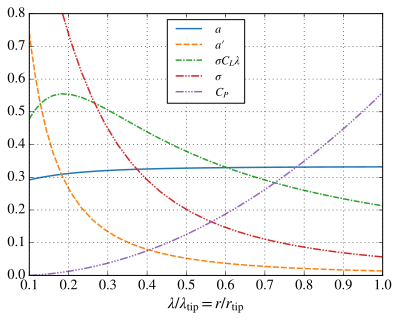

In [195]:
mpl.figure(2)
mpl.plot( dti.rR_vec, dti.a_vec,  label = r"$a$" )
mpl.plot( dti.rR_vec, dti.ap_vec, label = r"$a\prime$" )
mpl.plot( dti.rR_vec, dti.σCLλ_vec, label = r"$\sigma C_L \lambda$" )
mpl.plot( dti.rR_vec, dti.σ_vec, label = r"$\sigma$" )
mpl.plot( dti.rR_vec, dti.CP_vec, label = r"$C_P$" )

mpl.xlabel( r"$\lambda/\lambda_\mathrm{tip}=r/r_\mathrm{tip}$")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
mpl.ylim( ( 0.0, 0.8 ) )

mpl.savefig( "Glauert_Results.pdf" )

In [196]:
if print_tables:

    df = pd.DataFrame( { r"$\lambda$": dti.λ_vec,
                     r"$a$": dti.a_vec,
                     r"$a'$": dti.ap_vec,
                     r"$\phi_0$": dti.ϕ0_rad_vec*rad2deg,
                     r"$C_P$": dti.CP_vec,
                     r"$\sigma C_L \lambda$": dti.σCLλ_vec,
                     r"$\sigma$": dti.σ_vec
                    } )

    # print( df.to_latex(index=False,
    #        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
    #                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
    # ))
    display(df)

## Computing the turbine blade geometry for Glauert's solution

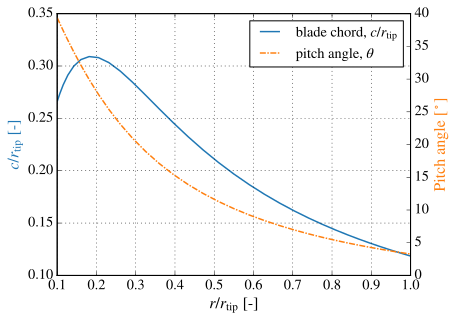

In [197]:
mpl.figure(3)
ax1 = mpl.gca()
ax1.plot( dti.rR_vec, dti.cR_vec, mut.linecolors[0], label=r"blade chord, $c/r_\mathrm{tip}$" )
ax1.set_ylabel( r"$c/r_\mathrm{tip}$ [-]", color=mut.linecolors[0] )
ax1.set_xlabel( r"$r/r_\mathrm{tip}$ [-]")
ax1.grid()

ax2 = mpl.gca().twinx()
ax2.plot( dti.rR_vec, dti.θ_rad_vec * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( r"Pitch angle [$^\circ$]", color=mut.linecolors[1] )
# ax2.set_ylim( 0, 50 )
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

mpl.savefig( "Glauert_BladeGeometry.pdf" )

# **Part 2** - Blade design with tip loss and chord length corrections

In [198]:
def tip_loss( Z, a, ap, ϕ0, λ, λtip ):
    ff = 0.5 * Z * np.abs( λtip / λ - 1 ) * np.sqrt( 1 + ( λ / ( 1 - a ) )**2 )
    rr =  np.max( ( 2.0 / np.pi * np.arccos( np.exp( -ff ) ), 1E-3 ) )
    return rr

In [199]:
def CT_Glauert( a, k ):
    return 4 * k * a * ( 1 - a )

def CT_Spera( a, k, ac ):
    # Spera's correction, PDF pp. 316
    return 4*k * (ac**2 + ( 1 - 2*ac )*a )

def CT_high_load( a, k ):
    ac = 1/3
    if a < ac:
        return CT_Glauert( a, k )
    else:
        return CT_Spera( a, k, ac )

In [200]:
def design_objective( x, λ, σ ):

    ( a, ap ) = x

    ϕ0 = np.atan2( ( 1 - a ), ( 1 + ap ) * λ )
    cosϕ0 = np.cos( ϕ0 )
    sinϕ0 = np.sin( ϕ0 )

    Ca = CL_des * cosϕ0 + CD_des * sinϕ0
    Ct = CL_des * sinϕ0 - CD_des * cosϕ0

    err_a  = CT_high_load( a, 1 )  - ( 1 - a )**2 * σ * Ca / ( sinϕ0*sinϕ0 )
    err_ap = 4*ap - ( 1 + ap ) * σ * Ct / ( cosϕ0 * sinϕ0 )

    return err_a**2 + err_ap**2

In [201]:
# The initial viscous solution is the invisc flow results
dtv = deepcopy( dti ) # deepcopy avoids references

try:
    x0 = np.array( [ dti.a_vec[0], dti.a_vec[0] ] )
    lb = [0.0,0.0]
    ub = [0.4,1.0]
    A = [ [1, 0], [0, 1] ]
    lcons = LinearConstraint( A, lb=lb, ub=ub, keep_feasible=True )

    for i, λ in enumerate( dti.λ_vec ):

        σ = dtv.σ_vec[i]

        func = lambda x: design_objective( x, λ, σ )
        res = minimize( func, x0, method='trust-constr',
                        options={'gtol': 1e-8, 'disp': False},
                        constraints=lcons )
        if res.success == False:
            raise RuntimeError( f"Solution did not converged for section {i}" )

        a, ap = x0 = res.x
        ϕ0 = np.atan2( ( 1 - a ), ( 1 + ap ) * λ )

        dtv.a_vec[i] = a
        dtv.ap_vec[i] = ap
        dtv.ϕ0_rad_vec[i] = ϕ0
        dtv.k_vec[i] = tip_loss( Z, a, ap, ϕ0, λ, dtv.λ_tip )
        dtv.θ_rad_vec[i] = ϕ0 - α_des_rad

    # computed the chord length
    σ_factor = 2.0 * np.pi / Z
    dtv.rR_vec = dtv.λ_vec / dtv.λ_tip
    dtv.cR_vec = dtv.σ_vec * σ_factor *  dtv.rR_vec * dtv.k_vec

    # integrate CP using trapezoidal rule
    CP = 0
    fct = 8 / dtv.λ_tip**2

    for i in range( 1, len( dti.λ_vec ) ):
        k = i - 1
        d_λ = ( dtv.λ_vec[i] - dtv.λ_vec[k] )

        f_k = dtv.k_vec[k] * dtv.ap_vec[k] * ( 1 - dtv.a_vec[k] ) * dtv.λ_vec[k]**3
        f_i = dtv.k_vec[i] * dtv.ap_vec[i] * ( 1 - dtv.a_vec[i] ) * dtv.λ_vec[i]**3

        dtv.CP_vec[i] = CP = CP + fct * 0.5 * ( f_i + f_k ) * d_λ

    print( f"C_P = {CP:.4f} -> Viscous solution" )

except RuntimeError as e:
    print( f"ERROR: {e}" )

C_P = 0.4470 -> Viscous solution


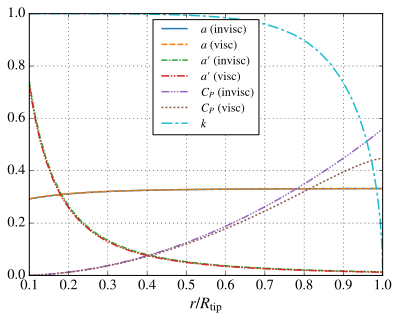

In [202]:
mpl.figure(4)
mpl.plot( dti.rR_vec, dti.a_vec,  label = r"$a$ (invisc)" )
mpl.plot( dtv.rR_vec, dtv.a_vec,  label = r"$a$ (visc)" )

mpl.plot( dti.rR_vec, dti.ap_vec, label = r"$a\prime$ (invisc)" )
mpl.plot( dtv.rR_vec, dtv.ap_vec, label = r"$a\prime$ (visc)" )

mpl.plot( dti.rR_vec, dti.CP_vec, label = r"$C_P$ (invisc)" )
mpl.plot( dtv.rR_vec, dtv.CP_vec, label = r"$C_P$ (visc)" )

mpl.plot( dtv.rR_vec, dtv.k_vec,  label = r"$k$" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
mpl.savefig( "Viscous_Results.pdf" )

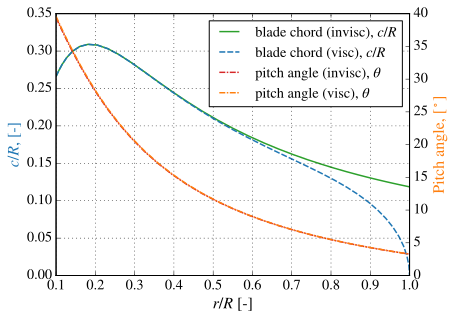

In [203]:
mpl.figure(5)
ax1 = mpl.gca()

ax1.plot( dti.rR_vec, dti.cR_vec, mut.linecolors[2], label=r"blade chord (invisc), $c/R$" )
ax1.plot( dtv.rR_vec, dtv.cR_vec, mut.linecolors[0], label=r"blade chord (visc), $c/R$" )
ax1.set_ylabel( r"$c/R$, [-]", color=mut.linecolors[0] )
ax1.set_xlabel( r"$r/R$ [-]")
ax1.grid()

ax2 = mpl.gca().twinx()
ax2.plot( dti.rR_vec, dti.θ_rad_vec * rad2deg, mut.linecolors[3], \
          dashes=mut.linestyles[2], label=r'pitch angle (invisc), $\theta$' )
ax2.plot( dtv.rR_vec, dtv.θ_rad_vec * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle (visc), $\theta$' )

ax2.tick_params(axis='y' )
ax2.set_ylabel( r"Pitch angle, [$^\circ$]", color=mut.linecolors[1] )
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

mpl.savefig( "Viscous_BladeGeometry.pdf" )

In [204]:
if print_tables:

    df = pd.DataFrame( { r"$\lambda$": dtv.λ_vec,
                        r"$a$": dtv.a_vec,
                        r"$a'$": dtv.ap_vec,
                        r"$\phi_0$": dtv.ϕ0_rad_vec*rad2deg,
                        r"$\sigma C_L \lambda$": dtv.σCLλ_vec,
                        r"$\sigma$": dtv.σ_vec
                        } )

    # print( df.to_latex(index=False,
    #        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
    #                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
    # ))
    display(df)

## **Off-design conditions** for a single operating point

In [205]:
def off_design_objective( x, λ, σ, θ, Z, λ_tip, k_des ):

    ( a, ap ) = x

    ϕ0 = np.atan2( ( 1 - a ), ( 1 + ap ) * λ )
    cosϕ0 = np.cos( ϕ0 )
    sinϕ0 = np.sin( ϕ0 )

    α = ϕ0 - θ
    CL, CD = Hydrofoil.data( α * rad2deg )

    Ca = CL * cosϕ0 + CD * sinϕ0
    Ct = CL * sinϕ0 - CD * cosϕ0

    ko = tip_loss( Z, a, ap, ϕ0, λ, λ_tip )
    rat_k = k_des / ko if ko != k_des else 1
    σR = σ * rat_k

    err_a  = CT_high_load( a, 1 )  - ( 1 - a )**2 * σR * Ca / ( sinϕ0*sinϕ0 )
    err_ap = 4*ap - ( 1 + ap ) * σR * Ct / ( sinϕ0*cosϕ0 )

    return err_a**2 + err_ap**2

In [217]:
def CP_OffDesign( λ_off, data_des ):

    CP = 0

    rat = λ_off / data_des.λ_tip
    dto = BladeData( data_des.λ_hub * rat, data_des.λ_tip * rat, data_des.n )

    λ_tip = dto.λ_tip

    a = ap = ϕ0 = α = CL = CD = 0

    x0 = np.array( [ dtv.a_vec[0], dtv.a_vec[0] ] )

    lb = [0.0,0.0]
    ub = [.7,3]
    A = [ [1, 0], [0, 1] ]
    lcons = LinearConstraint(A, lb=lb, ub=ub, keep_feasible=True)

    for i, λ in enumerate( dto.λ_vec ):

        if i == 0:
            a  = data_des.a_vec[i]
            ap = data_des.ap_vec[i]

        σ = data_des.σ_vec[i]
        θ = data_des.θ_rad_vec[i]
        k_des = data_des.k_vec[i]

        func = lambda x: off_design_objective( x, λ, σ, θ, Z, λ_tip, k_des )
        res = minimize( func, x0, method='trust-constr', \
                        options={'gtol': 1e-9, 'disp': False}, constraints=lcons )
        ( a, ap ) = x0 = res.x

        ϕ0 = np.atan2( ( 1 - a ), ( 1 + ap ) * λ )

        if res.success == False:
            raise RuntimeError( f"Solution did not converged for section {i}" )

        dto.a_vec[i] = a
        dto.ap_vec[i] = ap
        dto.k_vec[i] = tip_loss( Z, a, ap, ϕ0, λ, dto.λ_tip )
        dto.σ_vec[i] = σ
        dto.ϕ0_rad_vec[i] = ϕ0

        dto.α_rad_vec[i] = α
        dto.CL_vec[i] = CL
        dto.CD_vec[i] = CD

    dto.rR_vec = dto.λ_vec / dto.λ_tip

    # integrate CP using trapezoidal rule
    fct = 8 / dto.λ_tip**2

    for i in range( 1, len( dto.λ_vec ) ):
        k = i - 1
        d_λ = ( dto.λ_vec[i] - dto.λ_vec[k] )

        f_k = dto.k_vec[k] * dto.ap_vec[k] * ( 1 - dto.a_vec[k] ) * dto.λ_vec[k]**3
        f_i = dto.k_vec[i] * dto.ap_vec[i] * ( 1 - dto.a_vec[i] ) * dto.λ_vec[i]**3

        dto.CP_vec[i] = CP = CP + fct * 0.5 * ( f_i + f_k ) * d_λ

    return CP, dto

In [225]:
λ_off = 8.5

try:
    CP, dto = CP_OffDesign( λ_off, dtv )
    print( f"λ_off = {λ_off:.2f}, C_P = {CP:.4f} -> Viscous flow" )

except RuntimeError as e:
    print( f"ERROR: {e}" )

λ_off = 8.50, C_P = 0.3311 -> Viscous flow


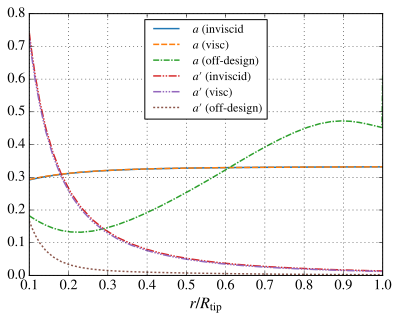

In [226]:
mpl.figure(6)

mpl.plot( dti.rR_vec, dti.a_vec,  label = r"$a$ (inviscid" )
mpl.plot( dtv.rR_vec, dtv.a_vec,  label = r"$a$ (visc)" )
mpl.plot( dto.rR_vec, dto.a_vec,  label = r"$a$ (off-design)" )

mpl.plot( dti.rR_vec, dti.ap_vec, label = r"$a\prime$ (inviscid)" )
mpl.plot( dtv.rR_vec, dtv.ap_vec, label = r"$a\prime$ (visc)" )
mpl.plot( dto.rR_vec, dto.ap_vec, label = r"$a\prime$ (off-design)" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()

In [222]:
if print_tables:

    df = pd.DataFrame( { r"$\lambda$": dto.λ_vec,
                        r"$a$": dto.a_vec,
                        r"$a'$": dto.ap_vec,
                        r"$\phi_0$": dto.ϕ0_rad_vec*rad2deg,
                        r"$\kappa$": dto.k_vec,
                        r"$\sigma$": dto.σ_vec,
                        r"$\alpha$": dto.α_rad_vec*rad2deg,
                        r"$C_L$": dto.CL_vec,
                        r"$C_D$": dto.CD_vec,
                        } )

    # print( df.to_latex(index=False,
    #        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
    #                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
    # ))
    display(df)

In [223]:
λ_off_min = 1.5
λ_off_max = 8.5
dλ_off = 0.2

no = int( (λ_off_max - λ_off_min) / dλ_off + 0.5 )
λ_off_vec = np.linspace( λ_off_min, λ_off_max, no )
CP_off_vec = []

try:
    for λ_off in λ_off_vec:

        CP, _ = CP_OffDesign( λ_off, dtv )
        CP_off_vec.append( CP )
        print( f"λ_off = {λ_off:5.2f}, C_P = {CP:.4f}" )

except RuntimeError as e:
    print( f"ERROR: {e}" )

λ_off =  1.50, C_P = 0.2910
λ_off =  1.71, C_P = 0.3142
λ_off =  1.91, C_P = 0.3350
λ_off =  2.12, C_P = 0.3536
λ_off =  2.32, C_P = 0.3703
λ_off =  2.53, C_P = 0.3851
λ_off =  2.74, C_P = 0.3982
λ_off =  2.94, C_P = 0.4097
λ_off =  3.15, C_P = 0.4197
λ_off =  3.35, C_P = 0.4283
λ_off =  3.56, C_P = 0.4355
λ_off =  3.76, C_P = 0.4416
λ_off =  3.97, C_P = 0.4464
λ_off =  4.18, C_P = 0.4502
λ_off =  4.38, C_P = 0.4530
λ_off =  4.59, C_P = 0.4550
λ_off =  4.79, C_P = 0.4561
λ_off =  5.00, C_P = 0.4564
λ_off =  5.21, C_P = 0.4559
λ_off =  5.41, C_P = 0.4545
λ_off =  5.62, C_P = 0.4524
λ_off =  5.82, C_P = 0.4495
λ_off =  6.03, C_P = 0.4457
λ_off =  6.24, C_P = 0.4411
λ_off =  6.44, C_P = 0.4356
λ_off =  6.65, C_P = 0.4293
λ_off =  6.85, C_P = 0.4221
λ_off =  7.06, C_P = 0.4141
λ_off =  7.26, C_P = 0.4051
λ_off =  7.47, C_P = 0.3953
λ_off =  7.68, C_P = 0.3845
λ_off =  7.88, C_P = 0.3726
λ_off =  8.09, C_P = 0.3598
λ_off =  8.29, C_P = 0.3461
λ_off =  8.50, C_P = 0.3311


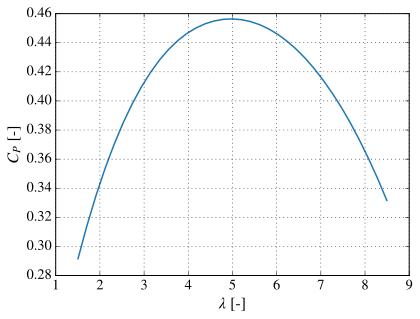

In [224]:
mpl.plot( λ_off_vec, CP_off_vec )
mpl.xlabel( r"$\lambda$ [-]")
mpl.ylabel( r"$C_P$ [-]")
mpl.grid()

In [135]:
def CT_Buhl( a, k ):
    CTa1=2
    return 4/9 * CTa1 + ( 4*k - 20/9*CTa1 ) * a + ( 25/9*CTa1 - 4*k ) * a**2

def CT_Glauert( a, k ):
    return 4 * k * a * ( 1 - a )

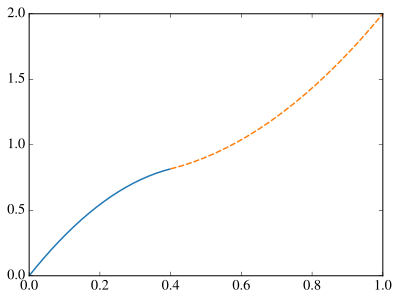

In [136]:
av1 = np.linspace( 0.0, 0.4, 20 )
av2 = np.linspace( 0.4, 1.0, 20 )

mpl.plot( av1, CT_Glauert( av1, 0.85 ) )
mpl.plot( av2, CT_Buhl( av2, 0.85 ) )

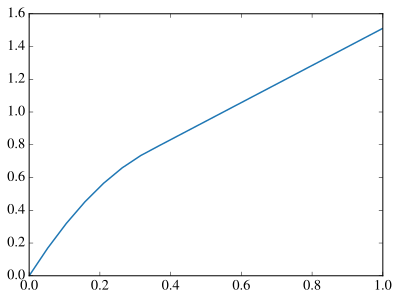

In [137]:
av3 = np.linspace( 0.0, 1.0, 20 )
CT = np.zeros_like( av3 )

for i, a in enumerate( av3 ):
    CT[i] = CT_high_load( a, 0.85 )

mpl.plot( av3, CT )